In [1]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import matplotlib.pyplot as plt

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.control.hscc.controllers import HybridModelPredictiveController

# Build predictive controller

The following loads the PWA model for the ball and paddle system and sets the parameters for the hybrid MPC controller.

In [2]:
# PWA system
from pwa_dynamics import S

# time steps
N = 20

# weight matrices
Q = np.diag([
    1., 1., .01,
    1., 1.,
    1., 1., .01,
    1., 1.
])*2. # (times 2 to cancel out the 1/2 in the controller code)
R = np.diag([
    .01, .001
])*2. # (times 2 to cancel out the 1/2 in the controller code)
P = np.zeros((S.nx, S.nx))

# terminal set
X_N = Polyhedron.from_bounds(*[np.zeros(S.nx)]*2)

# mixed-integer formulations and norms of the objective
methods = ['pf', 'ch', 'bm', 'mld']
norms = ['inf', 'one', 'two']

In [3]:
# initial condition
x0 = np.array([
    0., 0., np.pi,
    0., 0.,
    0., 0., 0.,
    0., 0.
])

# Table 3: comparison of mixed-integer formulations

The following solves one MICP for each norm and each mixed-integer formulation. In total there are 12 MICPs, 7 of which require more than 1 hour to be solved. The time limit is set to 1 hour: the following cell will take approximately 8 hours to run. However, the solution of any MICP can be stopped at any time pressing the 'interrupt kernel' button, and the partial result will still be saved.

Alternatively, the following cell can be skipped and the results can be loaded from the ``paper_data`` folder running:

``solves = np.load('paper_data/solves_flip_benchmark.npy').item()``

In [ ]:
# solves of the MICP with all the methods and the norms (takes hours!)
solves = {}
gurobi_options = {'OutputFlag': 1} # set OutputFlag to 0 to turn off gurobi log

# for all the norms of the objective
for norm in norms:
    
    solves[norm] = {}
    
    # for all the mixed-integer formulations
    for method in methods:
        print '\n-> norm:', norm
        print '-> method:', method, '\n'
        
        # build the copntroller
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        
        # kill solution if longer than 1h
        controller.prog.setParam('TimeLimit', 3600)
        
        # solve and store result
        u_mip, x_mip, ms_mip, cost_mip = controller.feedforward(x0, gurobi_options)
        solves[norm][method] = {
            'time': controller.prog.Runtime,
            'nodes': controller.prog.NodeCount,
            'mip_gap': controller.prog.MIPGap,
            'u': u_mip,
            'x': x_mip,
            'ms': ms_mip,
            'cost': cost_mip
        }

# save result
# np.save('paper_data/solves_flip_benchmark', solves)

In [ ]:
# loads the results above and prints the results
solves = np.load('paper_data/solves_flip_benchmark.npy').item()

In [ ]:
# print results
for norm in norms:
    for method in methods:
        print '\n-> norm:', norm
        print '-> method:', method
        print 'mip gap:', solves[norm][method]['mip_gap']
        print 'time:', solves[norm][method]['time']
        print 'nodes:', solves[norm][method]['nodes']

# Figure 4: animation of the optimal trajectory

The following cells use MeshCat (available at https://github.com/rdeits/meshcat-python) to generate an animation of the optimal trajectory of the ball and the paddle.

In [ ]:
import meshcat
import meshcat.transformations as tf
from meshcat.geometry import Box, Sphere, Cylinder, MeshLambertMaterial
from meshcat.animation import Animation

In [ ]:
# load solution
solves = np.load('paper_data/solves_flip_benchmark.npy').item()

In [ ]:
# initialize visualizer
vis = meshcat.Visualizer()
vis.open()

In [ ]:
# geometric parameters of the ball and the paddle
import numeric_parameters as params
tickness = .01
depth = .3

# colors of the scene
red = 0xff2222
blue = 0x2222ff
green = 0x22ff22
grey = 0x999999

# objects to animate
vis['ball'].set_object(
    Sphere(params.r),
    MeshLambertMaterial(color=blue)
)
vis['ball_stripe'].set_object(
    Cylinder(params.r/10., params.r*1.002), # a little larger than the ball to see it clearly
    MeshLambertMaterial(color=green)
)
vis['floor'].set_object(
    Box([depth, params.l*2., tickness]),
    MeshLambertMaterial(color=red)
)
vis['ceiling'].set_object(
    Box([depth, params.l*2., tickness]),
    MeshLambertMaterial(color=grey)
)

In [ ]:
# initialize animation
anim = Animation()

# animate, e.g., the solution with infinity norm (and convex-hull method -- irrelevant)
for t, xt in enumerate(solves['inf']['ch']['x']):
    with anim.at_frame(vis, t*params.h*30) as frame: # 30 frames per second to get real time
        frame['ball'].set_transform(
            tf.translation_matrix([0, xt[0], xt[1]+params.r])
        )
        frame['ball_stripe'].set_transform(
            tf.translation_matrix([0, xt[0], xt[1]+params.r]).dot(
                tf.rotation_matrix(xt[2], [1.,0.,0.])
            )
        )
        frame['floor'].set_transform(
            tf.translation_matrix([0, xt[3], xt[4]-tickness/2.])
        )
        frame['ceiling'].set_transform(
            tf.translation_matrix([0, 0, params.d+tickness/2.])
        )

# visualize result
vis.set_animation(anim)

# Figure 5: plot of the optimal mode sequence

In [ ]:
# load results
solves = np.load('paper_data/solves_flip_benchmark.npy').item()

# optimal mode sequence, e.g., in the infinity norm case
ms = solves['inf']['ch']['ms']

# double the initial mode for plot purposes
ms = [ms[0]] + ms

# names of the modes
ms_legend = [
    '',
    'Slide left on paddle',
    'Stick/roll on paddle',
    'Slide right on paddle',
    'No contact',
    'Slide left on ceiling',
    'Stick/roll on ceiling',
    'Slide right on ceiling'
]

# reorder the mode sequence in such a way that they match with the order of the names
ms_map = {0: 3, 1: 1, 2: 2, 3: 0, 4: 5, 5: 6, 6: 4}
ms_reordered = [ms_map[m] for m in ms]

In [ ]:
# change default size of matplotlib
plt.rc('font', size=16)

# initialize figure
plt.figure(figsize=(6,2.5))

# plot mode sequence
plt.step(range(N+1), ms_reordered, color='b')

# axis limits
plt.xlim(0, N)
plt.ylim(-.2, S.nm-.8)

# axis ticks
plt.xticks(range(N+1))
plt.gca().axes.xaxis.set_ticklabels([i if i%2==0 else '' for i in range(N+1)])
plt.yticks(range(-1,S.nm))
plt.gca().set_yticklabels(ms_legend)

# axis labels
plt.xlabel(r'Time step $t$')
plt.ylabel(r'System mode $i^*(t)$')

# misc
plt.grid(True)
# plt.savefig('optimal_mode_sequence.pdf',bbox_inches='tight')

# Figure 6: comparison of the formulations for different levels of relaxation

In [ ]:
# load solution
solves = np.load('paper_data/solves_flip_benchmark.npy').item()

In [ ]:
# cost of each relaxation as a function of the time step (takes approx. 2 minutes)
costs = {}
gurobi_options = {'OutputFlag': 0}

# for all the norms of the objective
for norm in norms:
    costs[norm] = {}
    
    # for all the mixed-integer formulations
    for method in methods:
        print '\n-> norm:', norm
        print '-> method:', method
        costs[norm][method] = []
        
        # build controller
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        
        # fix the mode of the system to its optimal value for the initial t steps
        for ms in [solves[norm]['ch']['ms'][:t] for t in range(N+1)]:
            
            # solve the relaxation and normalize on the optimal value of the MICP
            cost = controller.solve_relaxation(x0, ms, gurobi_options)[3]
            if cost is not None:
                cost /= solves[norm]['ch']['cost']
            costs[norm][method].append(cost)

In [ ]:
# change default colors and size of matplotlib
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
plt.rc('font', size=14)

# for all the norms of the objective
for norm in norms:
    
    # set line colors and styles
    colors = ['b', 'r', 'c','g']
    linestyles = ['-', '-.', '--', ':']
    
     # for all the mixed-integer formulations plot the relaxation ratio as a funtion of the time step
    for i, method in enumerate(methods):
        plt.plot(
            range(N+1),
            costs[norm][method],
            label=method.upper(),
            color=colors[i],
            linestyle=linestyles[i],
            linewidth=3
        )
        
    # axis limits
    plt.xlim((0, N))
    plt.ylim((0, 1.1))
    
    # plot titles
    if norm == 'inf':
        plt.title(r'$\infty$-norm objective')
    elif norm == 'one':
        plt.title(r'1-norm objective')
    elif norm == 'two':
        plt.title(r'Quadratic objective')
        
    # ticks
    plt.xticks(range(N+1)) # a tick per time step
    plt.gca().axes.xaxis.set_ticklabels([i if i%2==0 else '' for i in range(N+1)]) # label only even ticks
    
    # axis labels
    plt.xlabel(r'Time step $t$')
    plt.ylabel(r'Cost relaxed problem / cost MICP')

    # misc
    plt.legend(loc=4)
    plt.grid(True)
    # plt.savefig('relaxation_ratio_' + norm + '.pdf', bbox_inches='tight')
    plt.show()

# Table 2: objective as a function of the initial state ($x_1$ and $x_3$)

In the following we plot the optimal value function as a function of the initial state (only the horizontal position of the ball $x_1$, and the angle of the ball $x_3$).

For all the norms we first sample the optimal value function of the MICP on a 11 by 11 grid. This takes an extremely long time (approx. 3 days). However, the results of the samples can be loaded running:

``cost = np.load('paper_data/cost_micp_different_intial_conditions.npy').item()``

After plotting the optimal values for these samples, we solve the relaxation of the problem on a finer (51 by 51) for each norm and each mixed-integer formulation. This takes approx. 20 minutes.

## Table 2, Row 1: samples from the hybrid MPC value function

In [ ]:
# samples of the MICP optimal value (takes days!)

# load parameters
import numeric_parameters as params

# n_samples by n_samples grid in x1 and x3
n_samples = 11
xb_samples = np.linspace(0., params.x_max[0], n_samples)
tb_samples = np.linspace(-np.pi, np.pi, n_samples)

# cost of the MICP for each point
cost = {'xb_samples': xb_samples, 'tb_samples':tb_samples}
gurobi_options = {'OutputFlag': 1}

# for all the norms of the objective
for norm in norms:
    print '\nnorm:', norm
    
    # build controller
    controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, 'ch', norm)
    
    # cut after 5 h
    controller.prog.setParam('TimeLimit', 18000)
    
    # cost matrix
    cost_mat = np.empty([n_samples]*2)
        
    # solve one MICP program per point in the grid
    for i, xb in enumerate(xb_samples):
        for j, tb in enumerate(tb_samples):
            print(str(i) + ',' + str(j) + '   \r'),

            # initial state
            x0 = np.array([xb,0.,tb] + [0.]*7)
            
            # cost of the MICP
            cost_mat[i,j] = controller.feedforward(x0, gurobi_options)[3]
            
    # fill matrix
    cost[norm] = cost_mat

# save data
# np.save('paper_data/cost_micp_different_intial_conditions', cost)

In [ ]:
# plot cost of the MICP as a function of x1 and x3

# load parameters
import numeric_parameters as params

# change default size of matplotlib
plt.rc('font', size=18)

# load cost matrices
cost = np.load('paper_data/cost_micp_different_intial_conditions.npy').item()

# create grid x1 and x3
xb_samples = np.concatenate([[i]*len(cost['tb_samples']) for i in cost['xb_samples']])
tb_samples = cost['tb_samples'].tolist()*len(cost['xb_samples'])

# number of level curves in each plot
n_levels = 10

# for all the norms of the objective
for norm in norms:
    print '\nnorm:', norm
    
    # initialize figure
    plt.figure(figsize=(6., 2.3))
    
    # scatter the samples of the optimal value function
    c = cost[norm].flatten()
    sc = plt.scatter(
        xb_samples,
        tb_samples,
        c=c,
        cmap=plt.cm.get_cmap('viridis_r')
    )
    
    # get colorbar
    cb = plt.colorbar(sc)
    
    # colorbar ticks
    cb.set_ticks([min(c), max(c)])
    cb.set_ticklabels(['%.2f'%min(c),'%.2f'%max(c)])
    
    # axis limits
    plt.xlim(-.01,.31)
    plt.ylim(-np.pi-.3,np.pi+.3)
    
    # axis ticks
    plt.xticks(np.linspace(0., params.x_max[0], 6))
    plt.yticks(np.linspace(-np.pi, np.pi, 5))
    plt.gca().axes.yaxis.set_ticklabels([r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
    
    # misc
    plt.grid(True)
    plt.gca().set_axisbelow(True)
    # plt.savefig('cost_mip_' + norm + '.pdf',bbox_inches='tight')
    plt.show()

## Table 2, Remaining Rows: samples from convex relaxations of the MICPs

In [4]:
# solve relaxations for all MI formulations (takes tens of minutes)

# load parameters
import numeric_parameters as params

# n_samples by n_samples grid in x1 and x3
n_samples = 51
xb_samples = np.linspace(0., params.x_max[0], n_samples)
tb_samples = np.linspace(-np.pi, np.pi, n_samples)

# cost of the relaxation for each point
cost = {'xb_samples': xb_samples, 'tb_samples':tb_samples}
gurobi_options = {'OutputFlag': 0}

# for all the norms of the objective
for norm in norms:
    cost[norm] = {}
    
    # for all the mixed-integer formulations
    for method in methods:
        print '\n-> norm:', norm
        print '-> method:', method
        print 'Solving convex programs on a ' + str(n_samples) + ' by ' + str(n_samples) + ' grid:'
        
        # build controller
        controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
        
        # cost matrix
        cost_mat = np.empty([n_samples]*2)
        
        # solve one convex program per point in the grid
        for i, xb in enumerate(xb_samples):
            for j, tb in enumerate(tb_samples):
                print(str(i) + ',' + str(j) + '   \r'),
                
                # initial state
                x0 = np.array([xb,0.,tb] + [0.]*7)
                
                # cost of the relaxation
                cost_mat[i,j] = controller.solve_relaxation(x0, {}, gurobi_options)[3]
                
        # fill matrix
        cost[norm][method] = cost_mat

# save data
# np.save('paper_data/cost_relaxation_different_intial_conditions', cost)


-> norm: inf
-> method: pf
Solving convex programs on a 4 by 4 grid:
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
3,3   
-> norm: inf
-> method: ch
Solving convex programs on a 4 by 4 grid:
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
3,3   
-> norm: inf
-> method: bm
Solving convex programs on a 4 by 4 grid:
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
3,3   
-> norm: inf
-> method: mld
Solving convex programs on a 4 by 4 grid:
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
3,3   
-> norm: one
-> method: pf
Solving convex programs on a 4 by 4 grid:
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
3,3   
-> norm: one
-> method: ch
Solving convex programs on a 4 by 4 grid:
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
3,3   
-> norm: one
-> method: bm
Solving convex programs on a 4 by 4 grid:
Warni


norm: inf, method: pf


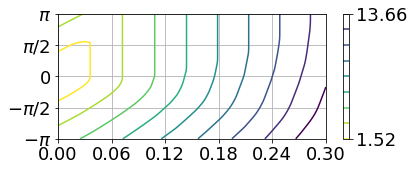


norm: inf, method: ch


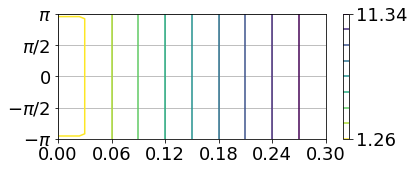


norm: inf, method: bm


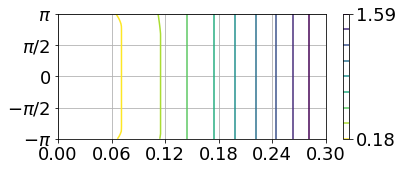


norm: inf, method: mld


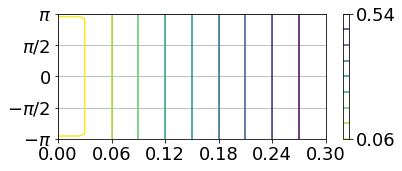


norm: one, method: pf


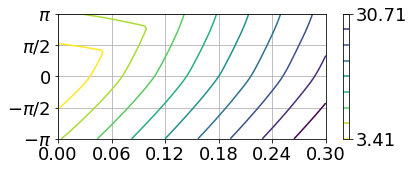


norm: one, method: ch


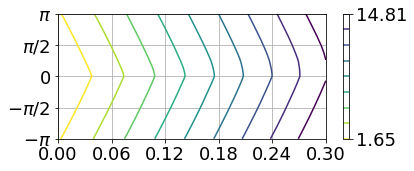


norm: one, method: bm


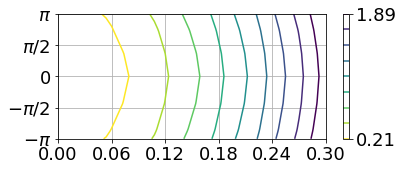


norm: one, method: mld


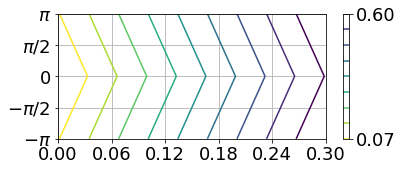


norm: two, method: pf


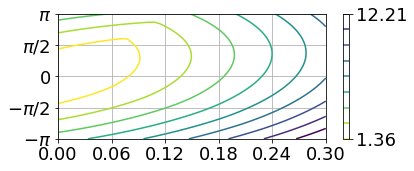


norm: two, method: ch


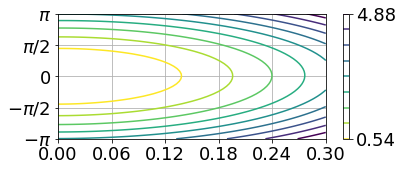


norm: two, method: bm


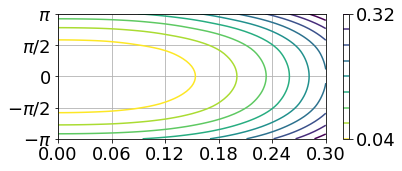


norm: two, method: mld


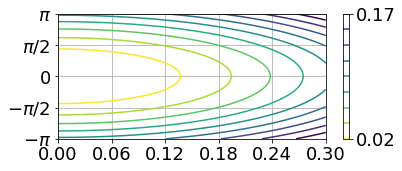

In [7]:
# plot cost of the relaxation as a function of x1 and x3

# load parameters
import numeric_parameters as params

# change default size of matplotlib
plt.rc('font', size=18)

# load cost matrices
cost = np.load('paper_data/cost_relaxation_different_intial_conditions.npy').item()

# create grid x1 and x3
xb_samples = cost['xb_samples']
tb_samples = cost['tb_samples']
Xb, Tb = np.meshgrid(xb_samples, tb_samples)

# number of level curves in each plot
n_levels = 10

# for all the norms of the objective
for norm in norms:
    
    # for all the mixed-integer formulations
    for method in methods:
        print '\nnorm: %s, method: %s' % (norm, method)
        
        # initialize figure
        plt.figure(figsize=(6., 2.3))
        
        # cost matrix
        cm = cost[norm][method]

        # set desired levels and draw the contour plot
        levels = [(i+1)*np.nanmax(cm)/n_levels for i in range(n_levels)]
        cp = plt.contour(Xb, Tb, cm.T, levels=levels, cmap='viridis_r')
        
        # get colorbar
        cb = plt.colorbar(cp)
        
        # ticks of the colorbar (only first and last) limited to 2 decimals
        cb.set_ticks([cb.locator()[0],cb.locator()[-1]])
        cb.set_ticklabels(['%.2f'%cb.locator()[0],'%.2f'%cb.locator()[-1]])
        
        # axis ticks
        plt.xticks(np.linspace(0., params.x_max[0], 6))
        plt.yticks(np.linspace(-np.pi, np.pi, 5))
        plt.gca().axes.yaxis.set_ticklabels([r'$-\pi$',r'$-\pi/2$',0,r'$\pi/2$',r'$\pi$'])
        
        # misc
        plt.grid(True)
        # plt.savefig('cost_' + method + '_' + norm + '.pdf',bbox_inches='tight')
        plt.show()